
<a id='jv'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Pesquisa de Emprego V: Na Busca por Emprego


<a id='index-1'></a>

## Conteúdo

- [Busca por Emprego V: Na Busca por Emprego](#Busca-por-Emprego-V:-Na-Busca-por-Emprego)  
  - [Resumo](#Resumo)  
  - [Modelo](#Modelo)  
  - [Implementação](#Implementação)  
  - [Resolvendo para Políticas](#Resolvendo-para-Políticas)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

### Características do modelo


<a id='index-2'></a>
- Acumulação de capital humano para emprego combinada com busca por emprego; e  
- Programação dinâmica de horizontes infinitos com umavariável de estado e duas de controle.  

### Configurações

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using Distributions, QuantEcon, Interpolations, Expectations, Parameters
using Plots, NLsolve, Random

## Modelo


<a id='index-3'></a>
Seja:

- $ x_t $ denota o capital humano para emprego no tempo -$ t $ de um trabalhador empregado em uma dada firma; e 
- $ w_t $ denota o total de vagas atuais.  


Seja $ w_t = x_t(1 - s_t - \phi_t) $, onde:

- $ \phi_t $  é o investimento em capital humano para emprego nas funções atuais; e  
- $ s_t $ é o esforço de busca, no sentido de obter ofertas novas de outras firmas.  


Enquanto o trabalhador permanecer no emprego atual, a evolução de $ \{x_t\} $ é dada por $ x_{t+1} = G(x_t, \phi_t) $.

Quando o esforço de busca $ t $ for $ s_t $, o trabalhador recebe uma nova oferta de trabalho com probabilidade $ \pi(s_t) \in [0, 1] $.

O valor da oferta é $ U_{t+1} $, onde $ \{U_t\} $ é iid com a distribuição $ F $.

O trabalhador tem o direito de rejeitar a oferta atual e continuar com o seu emprego.

Em particular, $ x_{t+1} = U_{t+1} $ se ele aceitar e $ x_{t+1} = G(x_t, \phi_t) $ se rejeitar.

Seja $ b_{t+1} \in \{0,1\} $ binária com $ b_{t+1} = 1 $ indicando uma oferta; podemos escrever:


<a id='equation-jd'></a>
$$
x_{t+1}
= (1 - b_{t+1}) G(x_t, \phi_t) + b_{t+1}
    \max \{ G(x_t, \phi_t), U_{t+1}\} \tag{1}
$$

Objetivo do agente: maximizar a soma esperada de salários descontados via controle de $ \{s_t\} $ e $ \{\phi_t\} $.

Tomando a expectativa de $ V(x_{t+1}) $ e usando [(1)](#equation-jd), a equação de Bellman para esse problema pode ser escrita como:


<a id='equation-jvbell'></a>
$$
V(x)
= \max_{s + \phi \leq 1}
    \left\{
        x (1 - s - \phi) + \beta (1 - \pi(s)) V[G(x, \phi)] +
        \beta \pi(s) \int V[G(x, \phi) \vee u] F(du)
     \right\}. \tag{2}
$$

Aqui a não-negatividade de $ s $ e $ \phi $ é entendida, enquanto $ a \vee b := \max\{a, b\} $.

### Parameterização


<a id='index-4'></a>
Na implementação abaixo, nós iremos focar na parametrização.

$$
G(x, \phi) = A (x \phi)^{\alpha},
\quad
\pi(s) = \sqrt s
\quad \text{and} \quad
F = \text{Beta}(2, 2)
$$

com os valores de parâmetros padrão:

- $ A = 1.4 $  
- $ \alpha = 0.6 $  
- $ \beta = 0.96 $  


A distribuição Beta(2,2) é mantida em $ (0,1) $. Tendo uma unimodal, a densidade simétrica atingiu o pico de 0.5.


<a id='jvboecalc'></a>

### Cálculos do verso do envelope

Antes de resolvermos o modelo, vamos fazer alguns rápidos cálculos que forneçam uma intuição e uma aparente solução.

Para começar, observe que o trabalhador tem dois instrumentos para construir capital e, consequentemente salários:

1. Investir em capital específico para o emprego atual via $ \phi $; e  
2. Procurar por um novo emprego com e melhor correspondência de capital específico do trabalho via $ s $.  


Desde que os salários sejam $ x (1 - s - \phi) $, o custo marginal do investimento ou $ \phi $ or $ s $ é idêntico.

Nosso trabalhador neutro ao risco deve se concentrar em qualquer intrumento com o maior retorno esperado.

O retorno esperado relativo dependerá de $ x $.

Por exemplo vamos supor inicialmente que $ x = 0.05 $

- Se $ s=1 $ e $ \phi = 0 $, então desde que $ G(x,\phi) = 0 $, assumir expectativas de [(1)](#equação-jd) fornecer um capital esperado para o próximo período igual a $ \ pi (s) \mathbb {E} U = \mathbb{E} U = 0.5 $.  
- Se $ s=0 $ e $ \phi=1 $, então o capital do próximo período será $ G(x, \phi) = G(0.05, 1) \approx 0.23 $.  


Ambas as taxas de retorno são boas, mas o retorno da procura por empregos é melhor ainda.

Vamos supor agora que $ x = 0.4 $.

- Se $ s=1 $ e $ \phi = 0 $, novamente o capital do próximo período será $ 0.5 $.  
- Se $ s=0 $ e$ \phi = 1 $, então $ G(x, \phi) = G(0.4, 1) \approx 0.8 $.  


O retorno do investimento via $ \phi $ domina o retorno esperado da busca.

A combinação dessas informações nos dá duas predições informais:

1. Em qualquer estado $ x $, os dois controles $ \ phi $ e $ s $ funcionarão principalmente como substitutos - o trabalhador se concentrará em qualquer instrumento que tenha o maior retorno esperado.
2. Para $ x $ suficientemente pequenos, a pesquisa será preferível ao investimento em capital humano específico do trabalho. Para $ x $ maiores, o inverso será verdadeiro.  


Agora vamos partir para a implementação, e ver se podemos combinar nossa predições.

## Implementação


<a id='index-5'></a>
O código a seguir resolve o problema DP descrito acima:

In [3]:
using Distributions, QuantEcon, Interpolations, Expectations, Parameters

  # model object
  function JvWorker(;A = 1.4,
              α = 0.6,
              β = 0.96,
              grid_size = 50,
              ϵ = 1e-4)

      G(x, ϕ) = A .* (x .* ϕ).^α
      π_func = sqrt
      F = Beta(2, 2)

      # expectation operator
      E = expectation(F)

      # Set up grid over the state space for DP
      # Max of grid is the max of a large quantile value for F and the
      # fixed point y = G(y, 1).
      grid_max = max(A^(1.0 / (1.0 - α)), quantile(F, 1 - ϵ))

      # range for range(ϵ, grid_max, grid_size). Needed for
      # CoordInterpGrid below
      x_grid = range(ϵ, grid_max, length = grid_size)

      return (A = A, α = α, β = β, x_grid = x_grid, G = G,
              π_func = π_func, F = F, E = E, ϵ = ϵ)
  end

function T!(jv,
                           V,
                           new_V::AbstractVector)

    # simplify notation
    @unpack G, π_func, F, β, E, ϵ = jv

    # prepare interpoland of value function
    Vf = LinearInterpolation(jv.x_grid, V, extrapolation_bc=Line())

    # instantiate the linesearch variables
    max_val = -1.0
    cur_val = 0.0
    max_s = 1.0
    max_ϕ = 1.0
    search_grid = range(ϵ, 1.0, length = 15)

    for (i, x) in enumerate(jv.x_grid)

        function w(z)
            s, ϕ = z
            h(u) = Vf(max(G(x, ϕ), u))
            integral = E(h)
            q = π_func(s) * integral + (1.0 - π_func(s)) * Vf(G(x, ϕ))

            return - x * (1.0 - ϕ - s) - β * q
        end

        for s in search_grid
            for ϕ in search_grid
                cur_val = ifelse(s + ϕ <= 1.0, -w((s, ϕ)), -1.0)
                if cur_val > max_val
                    max_val, max_s, max_ϕ = cur_val, s, ϕ
                end
            end
        end

        new_V[i] = max_val
    end
end

function T!(jv,
                           V,
                           out::Tuple{AbstractVector, AbstractVector})

    # simplify notation
    @unpack G, π_func, F, β, E, ϵ = jv

    # prepare interpoland of value function
    Vf = LinearInterpolation(jv.x_grid, V, extrapolation_bc=Line())

    # instantiate variables
    s_policy, ϕ_policy = out[1], out[2]

    # instantiate the linesearch variables
    max_val = -1.0
    cur_val = 0.0
    max_s = 1.0
    max_ϕ = 1.0
    search_grid = range(ϵ, 1.0, length = 15)

    for (i, x) in enumerate(jv.x_grid)

        function w(z)
            s, ϕ = z
            h(u) = Vf(max(G(x, ϕ), u))
            integral = E(h)
            q = π_func(s) * integral + (1.0 - π_func(s)) * Vf(G(x, ϕ))

            return - x * (1.0 - ϕ - s) - β * q
        end

        for s in search_grid
            for ϕ in search_grid
                cur_val = ifelse(s + ϕ <= 1.0, -w((s, ϕ)), -1.0)
                if cur_val > max_val
                    max_val, max_s, max_ϕ = cur_val, s, ϕ
                end
            end
        end

    s_policy[i], ϕ_policy[i] = max_s, max_ϕ
end
end

function T(jv, V; ret_policies = false)
    out = ifelse(ret_policies, (similar(V), similar(V)), similar(V))
    T!(jv, V, out)
    return out
end

T (generic function with 1 method)

O código é escrito para ser relativamente genérico - e consequentemente, reutilizável.

- Por exemplo, usamos $ G (x, \ phi) $ genérico em vez de $ A (x \ phi) ^ {\ alpha} $ específico.

Sobre as importações:

- `fixed_quad` é uma simples rotina de integração não-adaptativa.  
- `fmin_slsqp` é uma rotina de minimização que permite restrições de desigualdade.  


Em seguida escreveremos um construtor chamado `JvWorker`, que:

- Empacota todos os parâmetros e atributos básicos de um determinado modelo, e
- Implementa o método `T` para interação com a função valor.  


O método `T` toma uma candidata a função valor $ V $ e atualiza para $ TV $ via:

$$
TV(x)
= - \min_{s + \phi \leq 1} w(s, \phi)
$$

onde:


<a id='equation-defw'></a>
$$
w(s, \phi)
 := - \left\{
         x (1 - s - \phi) + \beta (1 - \pi(s)) V[G(x, \phi)] +
         \beta \pi(s) \int V[G(x, \phi) \vee u] F(du)
\right\} \tag{3}
$$

Aqui estamos minimizando, em vez de maximizar, para se ajustar às rotinas de otimização.

Quando nós representamos $ V $, será com uma matriz Julia `V` atribuíndo valores a `x_grid`.

Mas, para avaliar o lado direito de [(3)](#equation-defw), precisamos de uma função, portanto substituímos as matrizes `V` e` x_grid` pela função `Vf` que fornece interpolação linear de` V` em `x_grid`.

Com isso, nas preliminares de `T`

- Da matriz `V`nós definimos uma interpolação linear `Vf` dos seus valores:  
  
  - `c1` é usado para implementar a restrição $ s + \phi \leq 1 $  
  - `c2` é usado para implementar $ s \geq \epsilon $, uma alternativa numérica estável para a verdadeira restrição $ s \geq 0 $  
  - `c3` faz o mesmo para $ \phi $.  
  


Dentro do `for` loop, para cada `x` na grid sobre o espaço de estado, nós configuramos a função $ w(z) = w(s, \phi) $ definida em [(3)](#equation-defw).

A função é minimizada sobre todos os pares factíveis $ (s, \phi) $, ou por pesquisa de força bruta sobre o grid, ou rotinas especializadas para solucionadores.

O último é muito mais rápido, mas a convergência para o ótimo global não é garantida. A busca em grid é uma maneira simples de verificar os resultados.

## Resolvendo para Políticas


<a id='index-6'></a>
Vamos plotar as políticas ótimas e ver com o que elas se parecem.

O código à seguir é dado por:

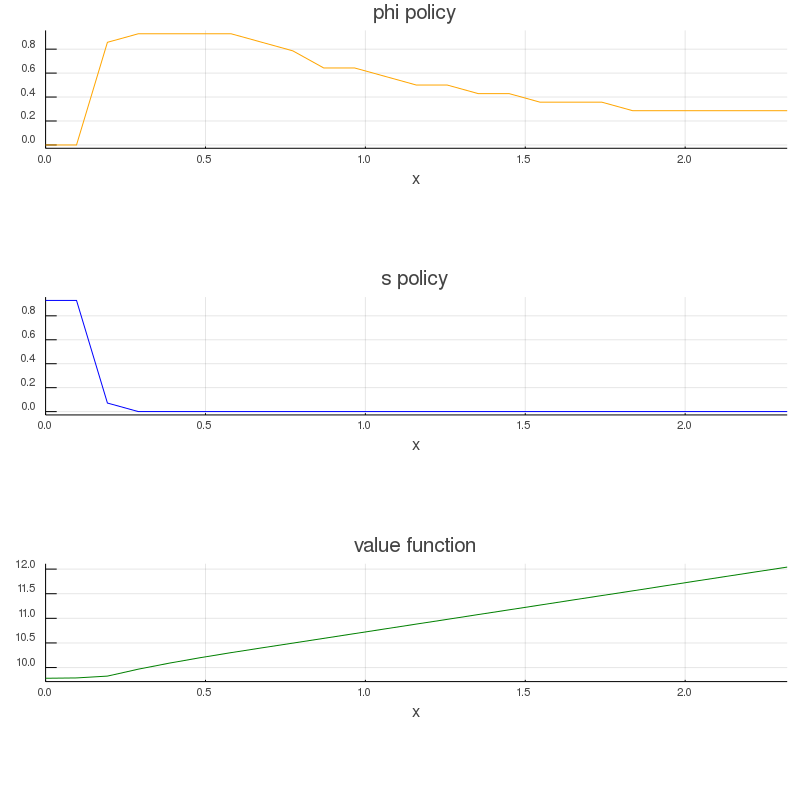

In [4]:
using Plots, NLsolve
gr(fmt=:png);

wp = JvWorker(grid_size=25)
v_init = collect(wp.x_grid) .* 0.5

f(x) = T(wp, x)
V = fixedpoint(f, v_init)
sol_V = V.zero

s_policy, ϕ_policy = T(wp, sol_V, ret_policies = true)

# plota a solução
p = plot(wp.x_grid, [ϕ_policy s_policy sol_V],
         title = ["phi policy" "s policy" "value function"],
         color = [:orange :blue :green],
         xaxis = ("x", (0.0, maximum(wp.x_grid))),
         yaxis = ((-0.1, 1.1)), size = (800, 800),
         legend = false, layout = (3, 1),
         bottom_margin = Plots.PlotMeasures.Length(:mm, 20))

O eixo horizontal é o estado $ x $, enquanto o eixo vertical dá $ s(x) $ e $ \phi(x) $.

No geral, as políticas combinam bem com nossas predições [vistas anteriormente](#jvboecalc).

- O trabalhador muda de uma estratégia de investimento para outra, dependendo do retorno relativo.
- Para valores baixos de $ x $, a melhor opção é procurar um novo emprego.
- Quando $ x $ é maior, o trabalhador se sai melhor investindo em capital humano específico para a posição atual.

## Exercícios


<a id='jv-ex1'></a>

### Exercício 1

Vamos olhar a dinâmica do processo de estado $ \{x_t\} $ associado à essas políticas.

A dinâmica é dada por [(1)](#equation-jd) quando $ \phi_t $ e $ s_t $ são escolhidos de acordo com as políticas ótimas, e $ \mathbb{P}\{b_{t+1} = 1\} = \pi(s_t) $.

Desde que essa dinâmica seja aleatória, a análise é um pouco sutil.

Uma maneira de fazer isso é plotar, para cada $ x $ em um grid relativamente fino chamado `plot_grid`, um grande número $ K $ de realizações de $ x_ {t + 1} $ com $ x_t = x $. Plote isso com um ponto para cada realização, na forma de um diagrama de 45 graus. Seja.

```julia
K = 50
plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = range(0, plot_grid_max, length = plot_grid_size)
plot(plot_grid, plot_grid, color = :black, linestyle = :dash,
     lims = (0, plot_grid_max), legend = :none)
```


Ao examinar o plot, argumente que, de acordo com as políticas ótimas, o estado $ x_t $ irá convergir para um valor constante $ \bar x $ próximo à unidade.

Argumente que, no estado estacionário, $ s_t \approx 0 $ e $ \phi_t \approx 0,6 $.

<a id='jv-ex2'></a>

### Exercício 2

No exercício anterior, descobrimos que $ s_t $ converge para zero e $ \phi_t $ converge para cerca de 0,6.

Como esses resultados foram calculados com um valor de $ \beta $ próximo a um, vamos compará-los com a melhor opção para um trabalhador *infinitamente* paciente.

Intuitivamente, um trabalhador infinitamente paciente gostaria de maximizar os salários no estado estacionário, que são uma função do capital do estado estacionário.

Você pode considerar como certo - é certamente verdade - que o trabalhador infinitamente paciente não pesquisa a longo prazo (ou seja, $ s_t = 0 $ para grandes $ t $).

Assim, dado $ \phi $, o capital de estado estável é o ponto fixo positivo $ x ^ * (\phi) $ do mapa $ x \mapsto G (x, \phi) $.

Os salários em estado estacionário podem ser escritos como $ w^*(\phi) = x^*(\phi) (1 - \phi) $.

Faça um gráfico de $ w^*(\phi) $ em relação a $ \phi $ e examine as melhores escolha de $ \phi $.

Você pode dar uma interpretação grosseira do valor que vê?

## Soluções

### Exercício 1

Aqui está o código para produzir um diagrama de 45 graus:

In [5]:
wp = JvWorker(grid_size=25)
# simplify notation
@unpack G, π_func, F = wp

v_init = collect(wp.x_grid) * 0.5
f2(x) = T(wp, x)
V2 = fixedpoint(f2, v_init)
sol_V2 = V2.zero
s_policy, ϕ_policy = T(wp, sol_V2, ret_policies=true)

# Ativar matrizes de função diretiva nos objetos CoordInterpGrid para interpolação
s = LinearInterpolation(wp.x_grid, s_policy, extrapolation_bc=Line())
ϕ = LinearInterpolation(wp.x_grid, ϕ_policy, extrapolation_bc=Line())

h_func(x, b, U) = (1 - b) * G(x, ϕ(x)) + b * max(G(x, ϕ(x)), U)

h_func (generic function with 1 method)

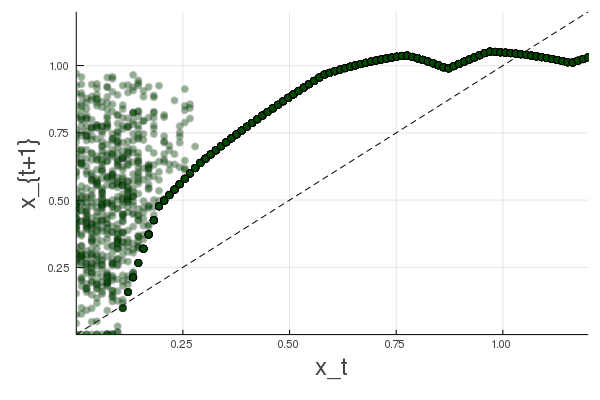

In [6]:
using Random
Random.seed!(42)
K = 50

plot_grid_max, plot_grid_size = 1.2, 100
plot_grid = range(0, plot_grid_max, length = plot_grid_size)
ticks = [0.25, 0.5, 0.75, 1.0]

xs = []
ys = []
for x in plot_grid
    for i=1:K
        b = rand() < π_func(s(x)) ? 1 : 0
        U = rand(wp.F)
        y = h_func(x, b, U)
        push!(xs, x)
        push!(ys, y)
    end
end

plot(plot_grid, plot_grid, color=:black, linestyle=:dash, legend=:none)
scatter!(xs, ys, alpha=0.25, color=:green, lims=(0, plot_grid_max), ticks=ticks)
plot!(xlabel="x_t", ylabel="x_{t+1}", guidefont=font(16))

Olhando para a dinâmica, podemos ver que:

- Se $ x_t $ estiver abaixo de 0,2, a dinâmica é aleatória, mas $ x_ {t + 1}> x_t $ é muito provável.
- À medida que $ x_t $ aumenta, a dinâmica se torna determinística e $ x_t $ converge para um valor de estado estacionário próximo a 1.

Referindo-se de volta à figura aqui.

[https://julia.quantecon.org/dynamic_programming/jv.html#Solving-for-Policies](https://julia.quantecon.org/dynamic_programming/jv.html#Solving-for-Policies)

nós vemos que $ x_t \approx 1 $ significa que
$ s_t = s(x_t) \approx 0 $ e
$ \phi_t = \phi(x_t) \approx 0.6 $.

### Exercise 2

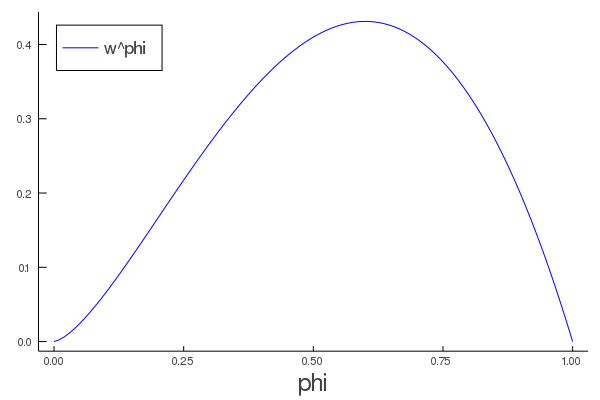

In [7]:
wp = JvWorker(grid_size=25)

xbar(ϕ) = (wp.A * ϕ^wp.α)^(1.0 / (1.0 - wp.α))

ϕ_grid = range(0, 1, length = 100)

plot(ϕ_grid, [xbar(ϕ) * (1 - ϕ) for ϕ in ϕ_grid], color = :blue,
     label = "w^phi", legendfont = font(12), xlabel = "phi",
     guidefont = font(16), grid = false, legend = :topleft)

Observe que o maximizador está em torno de 0,6.

Isso é semelhante ao valor de longo prazo para $ \phi $ obtido no exercício 1.

Portanto, o comportamento do trabalhador infinitamente patente é semelhante ao do trabalhador com $ \beta = 0,96 $.

Isso parece razoável e nos ajuda a confirmar que nossa programação dinâmica as soluções provavelmente estão corretas.